In [1]:
import torch
import pandas as pd
import os
import numpy as np

from bin.VisualiseUtils import visualize_specific_pedestrian_local, calculate_euclidean_distance
from src.Models.Mlp import MLP
from src.DataLoader.DataLoader import csv_string_to_list

# Dataframe setup

In [3]:
ann_file = os.path.join(os.path.pardir,
                        "Coco",
                        "annotations_trainval2017",
                        "person_keypoints_val2017.json")
image_folder_path = os.path.join(os.path.pardir, "Coco", "val2017")
data_path = os.path.join(os.path.pardir, "data","MLP_Approach","validation", "coco_validation_data.csv")
df = pd.read_csv(data_path)
df["keypoints"] = df["keypoints"].apply(csv_string_to_list)
df["target"] = df["target"].apply(csv_string_to_list)
df["img_id"] = df["img_id"].values
df["pedestrian_id"] = df["pedestrian_id"].values
df['score'] = np.nan
df['predictions'] = None

# Model Setup

In [5]:
input_size = 45
output_size = 2
layers = [256, 128, 64, 32]

model = MLP(input_size, output_size, layers)
model_path = os.path.join(os.path.pardir, "models", "20240229_155655_LR0.0001_BS16/final_model_epoch_25_rmse_0.0757.pth")
model.load_state_dict(torch.load(model_path))
model.eval()

MLP(
  (m_layers): Sequential(
    (Linear_1): Linear(in_features=45, out_features=256, bias=True)
    (Activation_1): ReLU()
    (Linear_2): Linear(in_features=256, out_features=128, bias=True)
    (Activation_2): ReLU()
    (Linear_3): Linear(in_features=128, out_features=64, bias=True)
    (Activation_3): ReLU()
    (Linear_4): Linear(in_features=64, out_features=32, bias=True)
    (Activation_4): ReLU()
    (Output): Linear(in_features=32, out_features=2, bias=True)
  )
)

# Prediction

In [6]:
predictions_list = []
for idx, row in df.iterrows():
    input_tensor = torch.tensor(row["keypoints"], dtype=torch.float32).unsqueeze(0)

    with torch.no_grad():
        prediction = model(input_tensor).squeeze().tolist()
    
    # Update score and prediction in dataframe
    score = calculate_euclidean_distance(prediction, row["target"])
    df.at[idx, 'score'] = score
    df.at[idx, 'predictions'] = prediction

    
# input_tensor = torch.tensor(df["keypoints"][img_idx], dtype=torch.float32)
# with torch.no_grad():
#     prediction = model(input_tensor)

# print(prediction)

# Visualization

In [7]:
# Sorting images in descending order 
worst_images = df.sort_values(by='score', ascending=False)
print(worst_images.head())

     origin  img_id  pedestrian_id                              bbox  \
1710   coco  393469         421984   [218.12, 371.66, 71.75, 159.28]   
291    coco  567640        2153512   [146.91, 58.46, 116.28, 280.61]   
701    coco   21879         547976     [84.39, 49.93, 111.94, 39.26]   
814    coco   93261        1721168    [65.72, 71.78, 198.69, 166.45]   
857    coco  122962        1705370  [440.96, 211.59, 102.89, 172.47]   

                                              keypoints  \
1710  [0.22132404181184662, 0.203038674033149, 2, 0....   
291   [0.7317681458548332, 0.1409073090766544, 2, 0....   
701   [0.8541182776487404, 0.3329088130412634, 2, 0....   
814   [0.8570134380190246, 0.10345449083808951, 1, 0...   
857   [0.38915346486539043, 0.27488838638603813, 2, ...   

                                         target     score  \
1710    [1.2039024390243902, 1.028628829733802]  0.642851   
291   [0.08247334021327832, 0.9177862513809201]  0.537703   
701   [0.23771663391102377, 0

In [8]:
# Extract images information
img_idx = 0
worst_img_id = worst_images.iloc[img_idx]['img_id']
worst_pedestrian_id = worst_images.iloc[img_idx]['pedestrian_id']
worst_prediction = worst_images.iloc[img_idx]['predictions']
worst_truth = worst_images.iloc[img_idx]['target']

In [9]:
print(worst_images.iloc[img_idx]['predictions'])

[0.6646522879600525, 1.3785804510116577]


loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


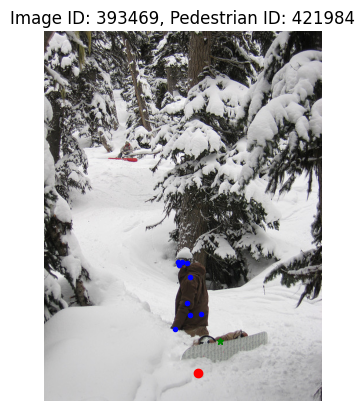

In [10]:
visualize_specific_pedestrian_local(ann_file, image_folder_path, worst_img_id, worst_pedestrian_id, worst_prediction, worst_truth)

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


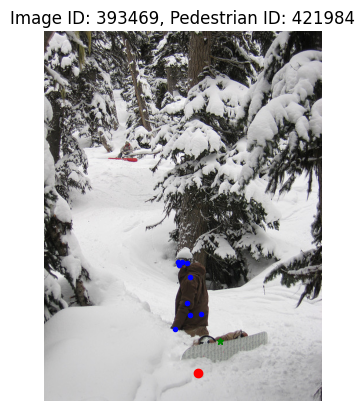

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


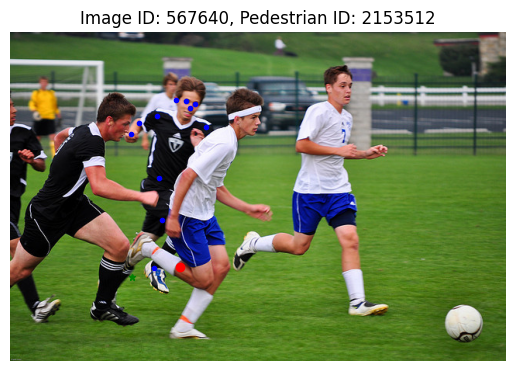

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


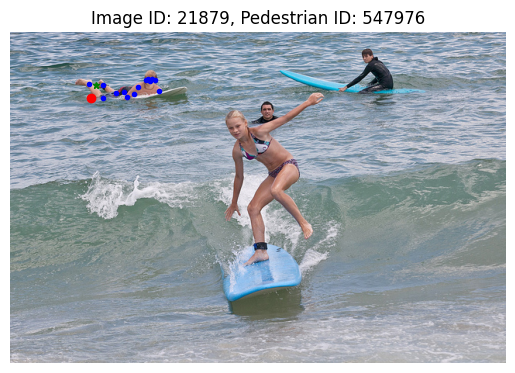

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


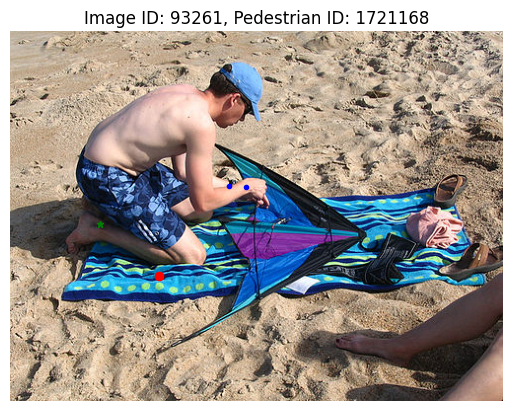

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


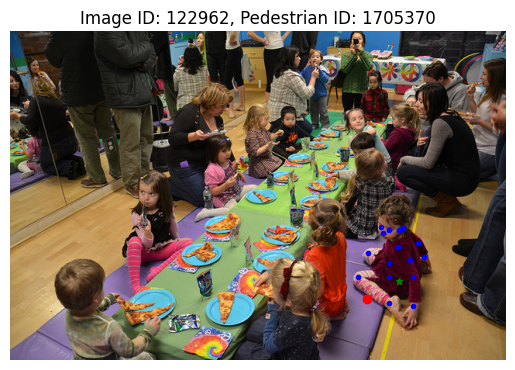

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


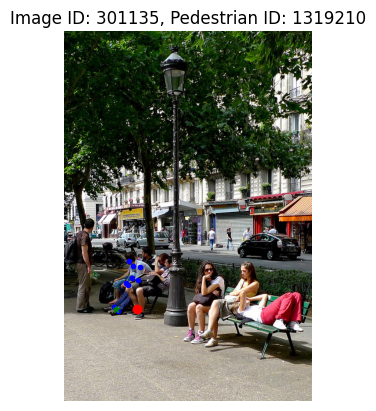

loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


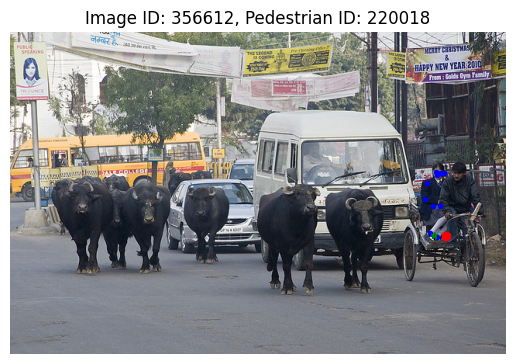

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


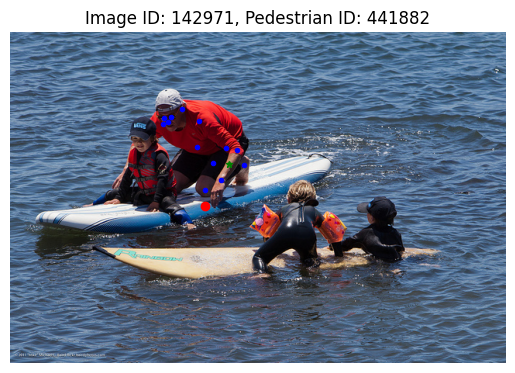

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


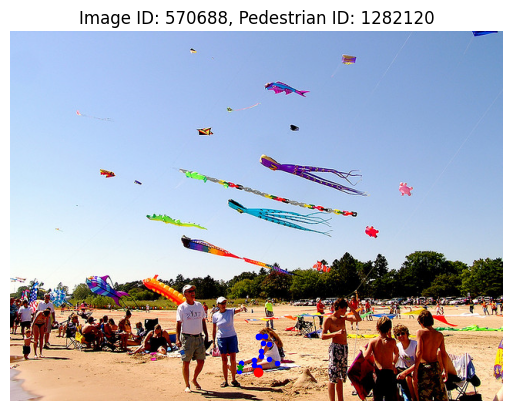

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


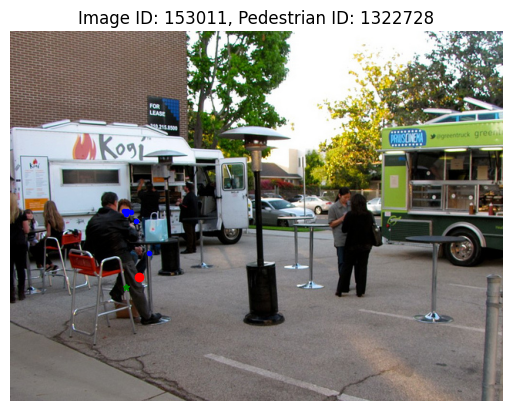

In [16]:
for index, row in worst_images.head(10).iterrows():
    visualize_specific_pedestrian_local(ann_file,
                                        image_folder_path,
                                        row['img_id'],
                                        row['pedestrian_id'],
                                        row['predictions'],
                                        row['target'])


In [13]:
best_images = df.sort_values(by='score', ascending=True)
print(worst_images.head())

     origin  img_id  pedestrian_id                              bbox  \
1710   coco  393469         421984   [218.12, 371.66, 71.75, 159.28]   
291    coco  567640        2153512   [146.91, 58.46, 116.28, 280.61]   
701    coco   21879         547976     [84.39, 49.93, 111.94, 39.26]   
814    coco   93261        1721168    [65.72, 71.78, 198.69, 166.45]   
857    coco  122962        1705370  [440.96, 211.59, 102.89, 172.47]   

                                              keypoints  \
1710  [0.22132404181184662, 0.203038674033149, 2, 0....   
291   [0.7317681458548332, 0.1409073090766544, 2, 0....   
701   [0.8541182776487404, 0.3329088130412634, 2, 0....   
814   [0.8570134380190246, 0.10345449083808951, 1, 0...   
857   [0.38915346486539043, 0.27488838638603813, 2, ...   

                                         target     score  \
1710    [1.2039024390243902, 1.028628829733802]  0.642851   
291   [0.08247334021327832, 0.9177862513809201]  0.537703   
701   [0.23771663391102377, 0

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


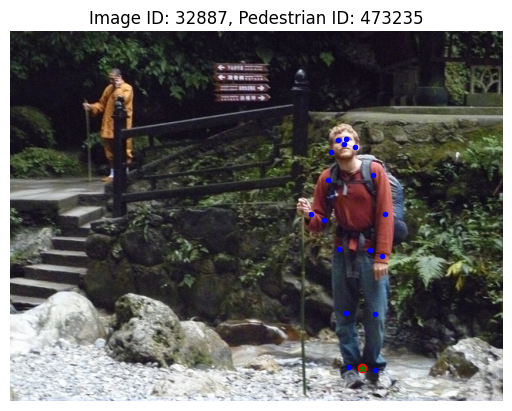

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


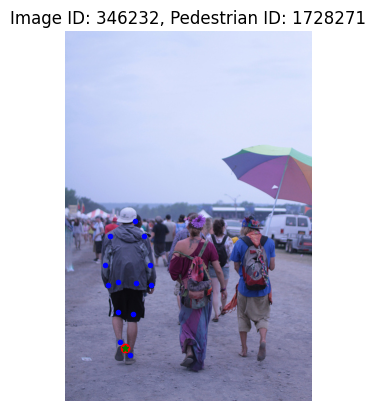

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


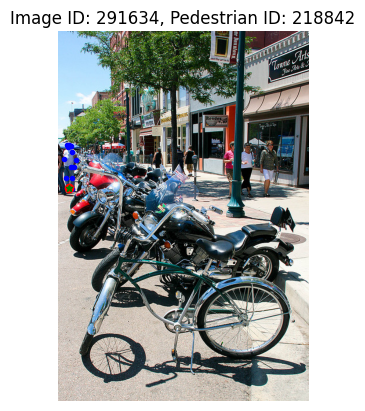

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


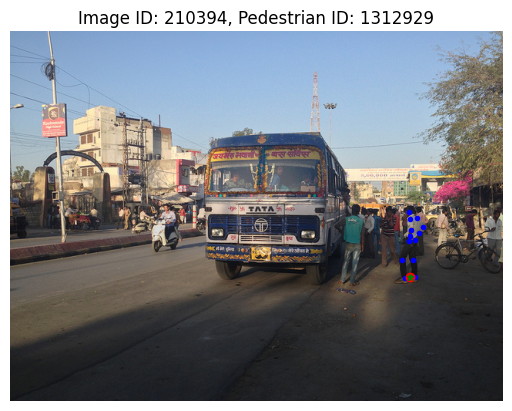

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


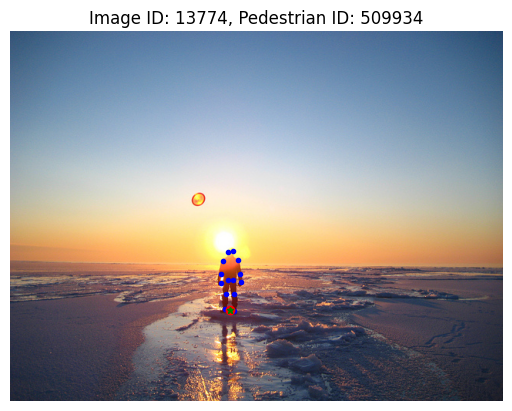

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


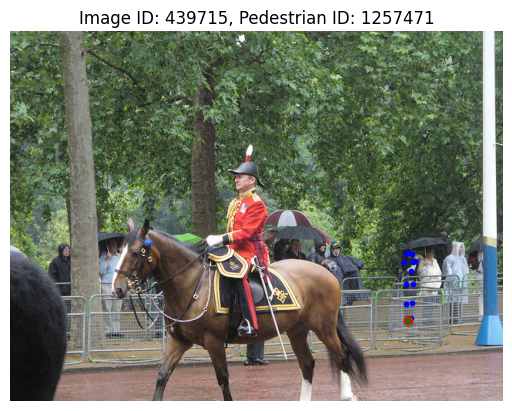

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


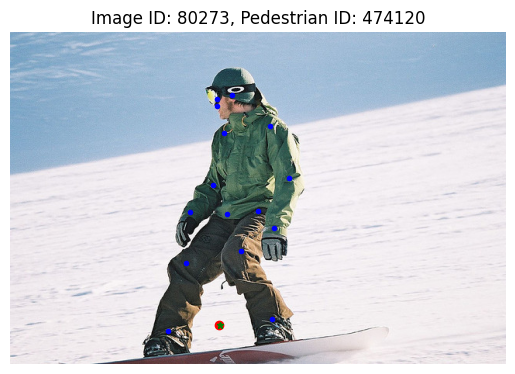

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


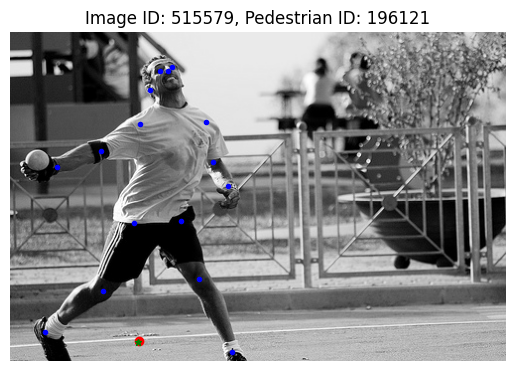

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


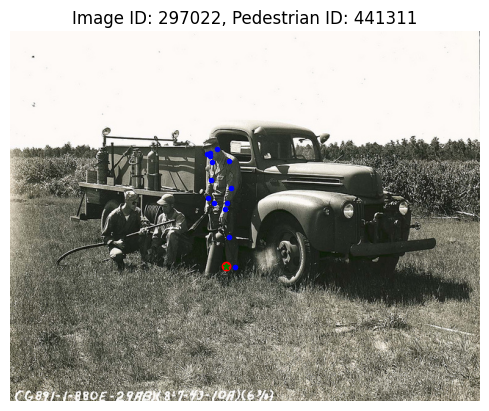

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


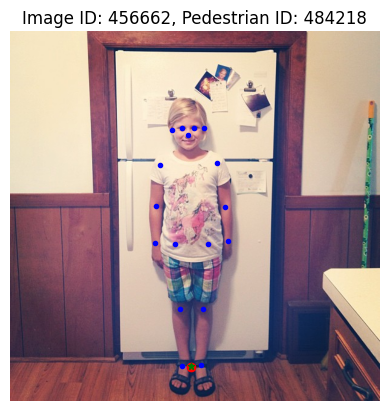

In [15]:
for index, row in best_images.head(10).iterrows():
    visualize_specific_pedestrian_local(ann_file,
                                        image_folder_path,
                                        row['img_id'],
                                        row['pedestrian_id'],
                                        row['predictions'],
                                        row['target'])